In [ ]:
! pip install -q kaggle
! pip install kagglehub

In [8]:
import kagglehub
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")

print("Path to dataset files:", path)

d:\Codes\projekt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ghous\.cache\kagglehub\datasets\sobhanmoosavi\us-accidents\versions\13


In [9]:
! cp C:\Users\ghous\.cache\kagglehub\datasets\sobhanmoosavi\us-accidents\versions\13\US_Accidents_March23.csv D:/Codes/projekt/

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import pandas as pd

file_path = 'US_Accidents_March23.csv'

denver_chunks = []

for chunk in pd.read_csv(file_path, chunksize=100000):
    filtered_chunk = chunk[(chunk['City'] == 'Denver') & (chunk['State'] == 'CO')]

    denver_chunks.append(filtered_chunk)

denver_subset = pd.concat(denver_chunks)

print(f"Successfully found {len(denver_subset)} records for Denver, CO.")
print(denver_subset.head())
output_path = "denver_accidents.csv"
denver_subset.to_csv(output_path, index=False)

print(f"Filtered data saved to {output_path}")

Successfully found 29658 records for Denver, CO.
              ID   Source  Severity           Start_Time             End_Time  \
512415  A-512446  Source2         3  2022-09-08 13:03:18  2022-09-08 13:32:26   
512594  A-512644  Source2         3  2022-09-08 08:42:23  2022-09-08 09:11:57   
512817  A-512894  Source2         2  2022-09-08 05:56:24  2022-09-08 06:27:00   
513226  A-513344  Source2         3  2022-09-07 18:07:28  2022-09-07 18:36:43   
513329  A-513455  Source2         3  2022-09-07 16:32:44  2022-09-07 17:01:57   

        Start_Lat   Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
512415  39.848122 -104.985306      NaN      NaN          0.00  ...      False   
512594  39.725094 -105.012817      NaN      NaN          0.00  ...      False   
512817  39.712692 -105.000298      NaN      NaN          0.00  ...      False   
513226  39.780067 -104.966911      NaN      NaN          2.34  ...      False   
513329  39.712692 -105.000298      NaN      NaN          1.

In [ ]:
import requests
import pandas as pd
import io
import time
from datetime import datetime

try:
    from zoneinfo import ZoneInfo
    def get_tz(name): return ZoneInfo(name)
except ImportError:
    import pytz
    def get_tz(name): return pytz.timezone(name)

STATION = "DEN"
START_YEAR = 2016
END_YEAR = 2023
OUTPUT_FILENAME = "denver_weather_records.csv"

BASE_URL = "https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py"

DATA_FIELDS = ["tmpf", "vsby", "p01i"]

def fetch_weather_for_year(year, station=STATION, fields=DATA_FIELDS):
    params = {
        "station": station,
        "data": ",".join(fields),
        "year1": year, "month1": 1, "day1": 1,
        "year2": year, "month2": 12, "day2": 31,
        "tz": "Etc/UTC",
        "format": "onlycomma",
        "latlon": "no",
        "direct": "no",
        "report_type": "3",
        "missing": "M"
    }

    print(f"Requesting data for {station} for the year {year}...")

    for attempt in range(5):
        try:
            r = requests.get(BASE_URL, params=params, timeout=60)
            if r.status_code == 200 and r.text and "station" in r.text:
                print(f"Successfully downloaded data for {year}.")
                return r.text
            else:
                print(f"Attempt {attempt + 1}: Failed to get valid data (Status: {r.status_code}). Retrying...")
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1}: An error occurred: {e}. Retrying...")

        time.sleep(2 ** attempt)

    print(f"Fatal: Could not download data for {year} after 5 attempts.")
    return None

def process_weather_data(csv_text, denver_tz):
    df = pd.read_csv(
        io.StringIO(csv_text),
        sep=",",
        comment='
        na_values=["M"]
    )

    df["datetime_utc"] = pd.to_datetime(df["valid"], errors='coerce', utc=True)
    df = df.dropna(subset=["datetime_utc"])

    df["DateTime"] = df["datetime_utc"].dt.tz_convert(denver_tz)

    df = df.rename(columns={
        "tmpf": "Temperature",
        "vsby": "Visibility",
        "p01i": "Precipitation"
    })

    df[["Temperature", "Visibility"]] = df[["Temperature", "Visibility"]].ffill().bfill()
    df["Precipitation"] = df["Precipitation"].fillna(0.0)

    df["Year"] = df["DateTime"].dt.year
    df["Month"] = df["DateTime"].dt.month
    df["Day"] = df["DateTime"].dt.day
    df["Hour"] = df["DateTime"].dt.hour
    df["Day of Week"] = df["DateTime"].dt.weekday

    final_columns = [
        "DateTime", "Year", "Month", "Day", "Hour", "Day of Week",
        "Temperature", "Visibility", "Precipitation"
    ]
    df_final = df[final_columns]

    return df_final.sort_values("DateTime").reset_index(drop=True)

if __name__ == "__main__":
    all_years_dfs = []
    denver_timezone = get_tz("America/Denver")

    for current_year in range(START_YEAR, END_YEAR + 1):
        raw_data = fetch_weather_for_year(current_year)
        if raw_data:
            yearly_df = process_weather_data(raw_data, denver_timezone)
            all_years_dfs.append(yearly_df)
        time.sleep(2)

    if all_years_dfs:
        final_df = pd.concat(all_years_dfs, ignore_index=True)

        final_df.to_csv(OUTPUT_FILENAME, index=False, date_format='%Y-%m-%d %H:%M:%S')

        print(f"\n✅ Success! File '{OUTPUT_FILENAME}' has been created with {len(final_df)} records.")
        print("Columns:", final_df.columns.tolist())
    else:
        print("\n❌ Failure. No data was downloaded. The output file was not created.")

Requesting data for DEN for the year 2016...
Successfully downloaded data for 2016.
Requesting data for DEN for the year 2017...
Successfully downloaded data for 2017.
Requesting data for DEN for the year 2018...
Successfully downloaded data for 2018.
Requesting data for DEN for the year 2019...
Successfully downloaded data for 2019.
Requesting data for DEN for the year 2020...
Successfully downloaded data for 2020.
Requesting data for DEN for the year 2021...
Successfully downloaded data for 2021.
Requesting data for DEN for the year 2022...
Successfully downloaded data for 2022.
Requesting data for DEN for the year 2023...
Successfully downloaded data for 2023.

✅ Success! File 'denver_weather_records.csv' has been created with 69812 records.
Columns: ['DateTime', 'Year', 'Month', 'Day', 'Hour', 'Day of Week', 'Temperature', 'Visibility', 'Precipitation']


In [12]:
df = pd.read_csv("denver_accident_records.csv")
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-512446,Source2,3,2022-09-08 13:03:18,2022-09-08 13:32:26,39.848122,-104.985306,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
1,A-512644,Source2,3,2022-09-08 08:42:23,2022-09-08 09:11:57,39.725094,-105.012817,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-512894,Source2,2,2022-09-08 05:56:24,2022-09-08 06:27:00,39.712692,-105.000298,NaN,NaN,0.00,...,False,False,False,False,False,False,Night,Night,Day,Day
3,A-513344,Source2,3,2022-09-07 18:07:28,2022-09-07 18:36:43,39.780067,-104.966911,NaN,NaN,2.34,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-513455,Source2,3,2022-09-07 16:32:44,2022-09-07 17:01:57,39.712692,-105.000298,NaN,NaN,1.94,...,False,False,False,False,False,False,Day,Day,Day,Day


In [13]:
weather_df = pd.read_csv("denver_weather_records.csv")
weather_df.head()

,DateTime,Year,Month,Day,Hour,Day of Week,Temperature,Visibility,Precipitation
0,2015-12-31 17:53:00,2015,12,31,17,3,11.0,6.0,0.0
1,2015-12-31 18:53:00,2015,12,31,18,3,9.0,5.0,0.0
2,2015-12-31 19:53:00,2015,12,31,19,3,9.0,5.0,0.0
3,2015-12-31 20:53:00,2015,12,31,20,3,5.0,7.0,0.0
4,2015-12-31 21:53:00,2015,12,31,21,3,12.0,7.0,0.0


In [ ]:
# feature engineering
df2 = df.copy(deep=True)

df2["Start_Time"] = pd.to_datetime(df2["Start_Time"], format='mixed')
df2["Hour_of_Day"] = df2["Start_Time"].dt.hour
df2["Day"] = df2["Start_Time"].dt.day
df2["Day_of_Week"] = df2["Start_Time"].dt.weekday
df2["Month"] = df2["Start_Time"].dt.month
df2["Year"] = df2["Start_Time"].dt.year

columns_to_drop = [
    'ID', 'Source', 'Start_Time', 'End_Time', 'End_Lat', 'End_Lng',
    'Distance(mi)', 'Description', 'County', 'Street', 'City', 'Country',
    'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
    'Weather_Timestamp', 'Turning_Loop', 'Roundabout'
] # Drop columns that are not useful for analysis
df2 = df2.drop(columns=columns_to_drop, axis=1)

for col in df2.columns:
    print(f"{col:>22} {str(df2[col].dtype):>10} {df2[col].isna().sum(axis=0):>10}", end=" ")
    if df2[col].isnull().sum(axis=0) > 0:
        if df2[col].dtype == 'object':
            df2[col] = df2[col].fillna(df2[col].mode()[0])
        else:
            df2[col] = df2[col].fillna(df2[col].median())
    print(f"{df2[col].isna().sum(axis=0):>10}")

              Severity      int64          0          0
             Start_Lat    float64          0          0
             Start_Lng    float64          0          0
        Temperature(F)    float64         46          0
         Wind_Chill(F)    float64       6411          0
           Humidity(%)    float64         56          0
          Pressure(in)    float64         24          0
        Visibility(mi)    float64         28          0
        Wind_Direction     object         55          0
       Wind_Speed(mph)    float64       2022          0
     Precipitation(in)    float64      10353          0
     Weather_Condition     object         39          0
               Amenity       bool          0          0
                  Bump       bool          0          0
              Crossing       bool          0          0
              Give_Way       bool          0          0
              Junction       bool          0          0
               No_Exit       bool          0    

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
categorical_cols = [
    'Wind_Direction', 'Weather_Condition', 'Weather_Condition',
    'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'
]
target = 'Severity'

le = LabelEncoder()
# Encode categorical features
for col in categorical_cols:
    df2.loc[:, col] = le.fit_transform(df2.loc[:, col].astype('str')).astype('int8')

weather_df["Year"] = pd.to_datetime(weather_df["DateTime"]).dt.year
weather_df["Day_of_Week"] = pd.to_datetime(weather_df["DateTime"]).dt.weekday
weather_df.head()

street_names = {}
for street_name in df["Street"].unique():
    street_names[street_name] = 0

replacers = {
    'Aly': 'Alley', 'Ave': 'Avenue', 'Blvd': 'Boulevard', 'Cir': 'Circle',
    'Ctr': 'Center', 'Dr': 'Drive', 'E': 'East', 'Fwy': 'Freeway', 'Hwy': 'Highway',
    'Ln': 'Lane', 'N': 'North', 'Pkwy': 'Parkway', 'Pl': 'Place', 'Rd': 'Road',
    'S': 'South', 'St': 'Street', 'Tpke': 'Turnpike', 'Trl': 'Trail Drive', 'W': 'West'
}
# standardize street names in both the dictionary and the dataframe


name_keys = list(street_names.keys())
for k in name_keys:
    s = str(k).split()
    new = ""
    for word in s:
        if word in replacers:
            new += replacers[word] + " "
        else:
            new += word + " "
    new = new[:-1]
    street_names[new] = street_names[k]
    del street_names[k]

for _, record in df.iterrows():
    s = str(record['Street']).split()
    new = ""
    for word in s:
        if word in replacers:
            new += replacers[word] + " "
        else:
            new += word + " "
    df.loc[_, 'Street'] = new[:-1]

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

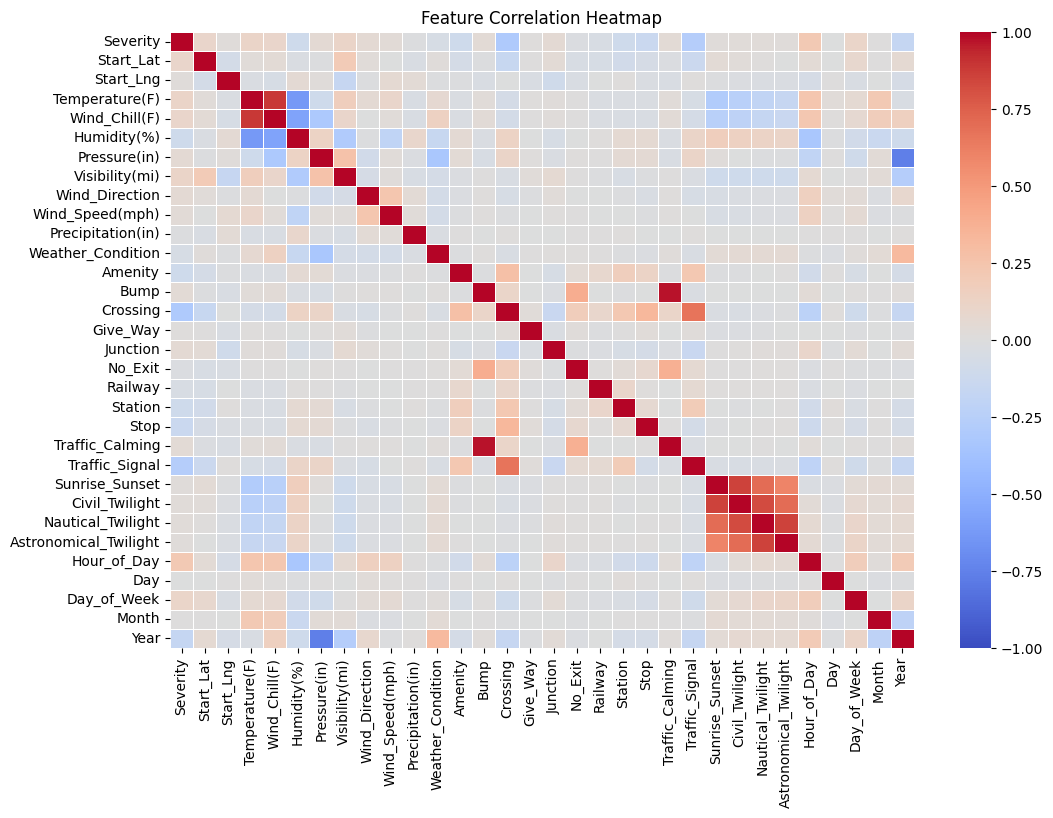

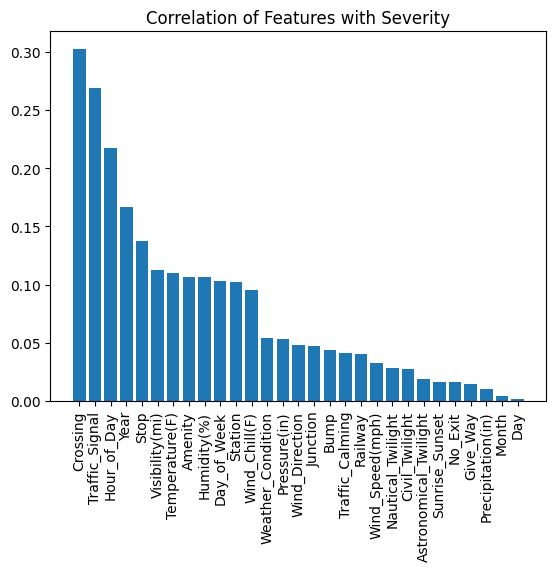

C:\Users\ghous\AppData\Local\Temp\ipykernel_78004\3257137759.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mi_matrix = pd.concat([mi_matrix, mi_results.to_frame(name=col).T])


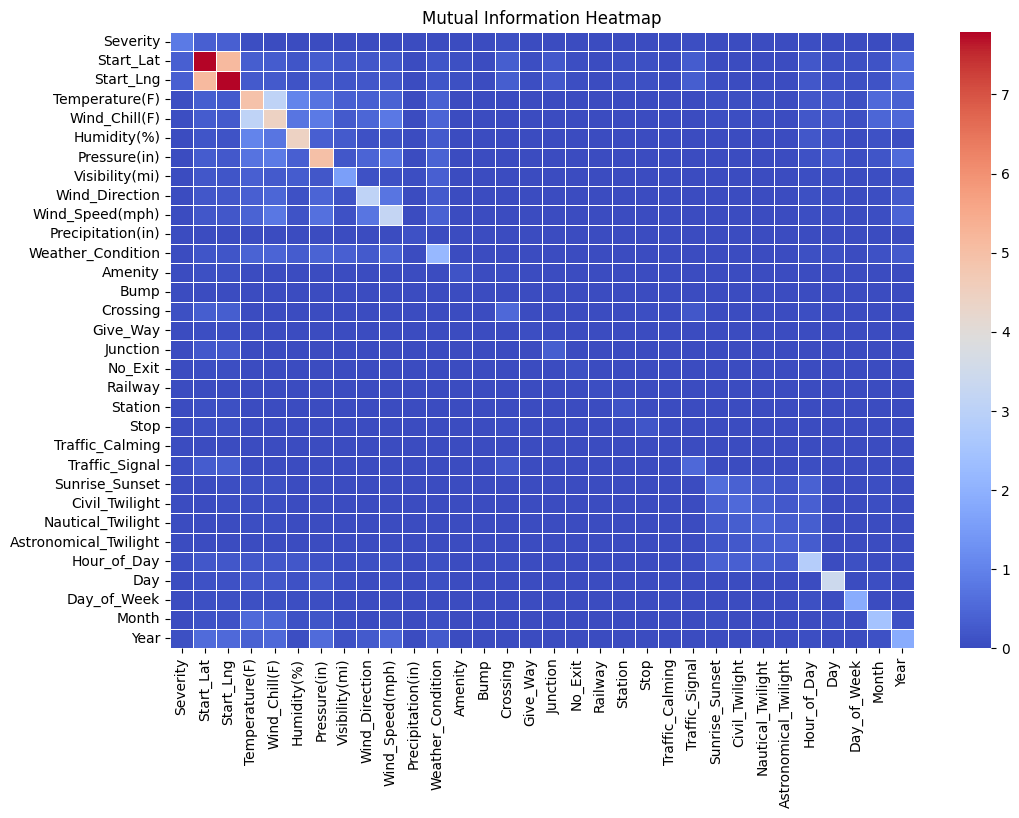

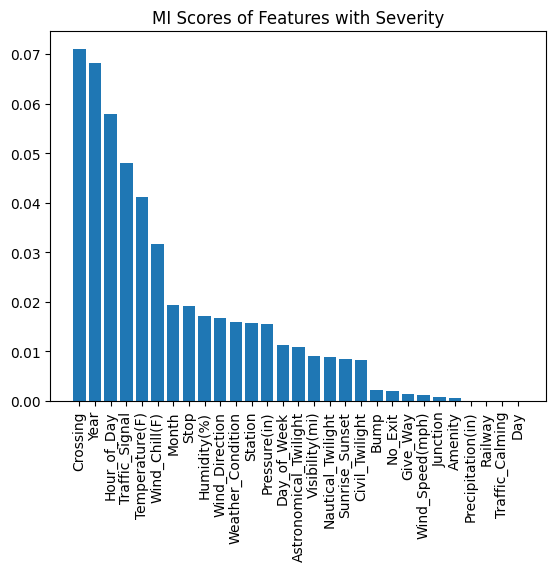

In [ ]:
df['Street']

corr_matrix = df2.corr()

# plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1
)
plt.title("Feature Correlation Heatmap")
plt.show()
# plot correlation values with target variable

corr_values = abs(
    corr_matrix['Severity']
    .drop(['Severity', 'Start_Lat', 'Start_Lng'])
).sort_values(ascending=False)

plt.bar(corr_values.index, corr_values)
plt.xticks(corr_values.index, rotation=90)
plt.title("Correlation of Features with Severity")
plt.show()

# Mutual Information
mi_matrix = pd.DataFrame(columns=df2.columns)
for col in df2.columns:
    if df2[col].dtype == 'object':
        mi_scores = mutual_info_classif(
            df2[df2.columns],
            df2[col].astype('int'),
            discrete_features="auto"
        )
    else:
        mi_scores = mutual_info_regression(
            df2[df2.columns],
            df2[col],
            discrete_features="auto"
        )
    mi_results = pd.Series(mi_scores, index=df2.columns).sort_values(ascending=False)
    mi_matrix = pd.concat([mi_matrix, mi_results.to_frame(name=col).T])

# plot MI heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mi_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mutual Information Heatmap")
plt.show()

# plot MI values with target variable
mi_results = mi_matrix.loc[:, "Severity"].drop(['Severity', 'Start_Lat', 'Start_Lng']).sort_values(ascending=False)
plt.bar(mi_results.index, mi_results)
plt.xticks(mi_results.index, rotation=90)
plt.title("MI Scores of Features with Severity")
plt.show()

In [23]:
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points


import osmnx as ox


from rtree import index


import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np

In [ ]:
# Create graph from OSM data
place_name = "Denver, Colorado, USA"
G = ox.graph_from_place(place_name, network_type="drive")
print(f"Denver Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Convert to undirected and project to lat-long
G = G.to_undirected()
G_proj = ox.project_graph(G, to_latlong=True)

# Create new graph where nodes are road segments
# and edges represent possible transitions between segments
segment_graph = nx.Graph()
segment_nodes = {}
segment_id = 0
no_name_count = 0

# Iterate over edges to create segment nodes
for u, v, data in G_proj.edges(data=True):
    segment_id += 1
    
    road_type = data.get('highway', 'unknown')
    speed_limit = data.get('maxspeed', 0)
    
    if isinstance(speed_limit, list):
        speed_limit = speed_limit[0] if speed_limit else 0
    try:
        speed_limit = float(str(speed_limit).split()[0])
    except Exception:
        speed_limit = 25.0

    lanes = data.get('lanes', 1)
    if isinstance(lanes, list):
        lanes = lanes[0] if lanes else 1
    try:
        lanes = int(lanes)
    except Exception:
        lanes = 1

    length = data.get('length', 0)

    x1, y1 = G_proj.nodes[u]['x'], G_proj.nodes[u]['y']
    x2, y2 = G_proj.nodes[v]['x'], G_proj.nodes[v]['y']
    geometry = LineString([(x1, y1), (x2, y2)])

    street_name = data.get('name', 'x')
    if street_name == 'x':
        no_name_count += 1

    segment_nodes[segment_id] = {
        'name': street_name,
        'road_type': road_type,
        'speed_limit': np.float16(speed_limit),
        'lanes': np.int8(lanes),
        'length': np.float16(length),
        'u': u,
        'v': v,
        'geometry': geometry,
        'amenity': False,
        'crossing': False,
        'station': False,
        'stop': False,
        'traffic_signal': False
    }

    segment_graph.add_node(segment_id)

node_segments = {}
for segment_id, data in segment_nodes.items():
    u, v = data['u'], data['v']
    if u not in node_segments:
        node_segments[u] = [[], []]
    if v not in node_segments:
        node_segments[v] = [[], []]
    node_segments[u][0].append(segment_id)
    node_segments[v][1].append(segment_id)

for node, (out_segments, in_segments) in node_segments.items():
    for i in in_segments:
        for j in out_segments:
            segment_graph.add_edge(i, j)

print(f"New Graph: {segment_graph.number_of_nodes()} nodes, {segment_graph.number_of_edges()} edges")

Denver Graph: 17001 nodes, 48604 edges
New Graph: 27752 nodes, 30238 edges


In [25]:
search_word = '100th'
no_such_roads = 0
yes_such_roads = 0
hmm_such_roads = 0

for segment_id, data in segment_nodes.items():
    if isinstance(data['name'], str):
        if data['name'] in street_names:
            street_names[data['name']] += 1
            yes_such_roads += 1
        elif search_word in data['name'].lower().split(" "):
            print(data['name'])
            hmm_such_roads += 1
        else:
            no_such_roads += 1
    elif isinstance(data['name'], list):
        for name in data['name']:
            if name in street_names:
                street_names[name] += 1
                yes_such_roads += 1
            elif search_word in name.lower().split(" "):
                print(data['name'])
                hmm_such_roads += 1
            else:
                no_such_roads += 1
    else:
        no_such_roads += 1

print("Exact name matches:", yes_such_roads)
print("Potential name matches:", hmm_such_roads)
print("No name matches:", no_such_roads)
print()
print("Total unique street names from dataset:", len(street_names))
print("Total segments in map:", len(segment_nodes))

idx = index.Index()
for segment_id, data in segment_nodes.items():
    minx, miny, maxx, maxy = data['geometry'].bounds
    idx.insert(segment_id, (minx, miny, maxx, maxy))

unnamed_count = 0
for u, v, data in G_proj.edges(data=True):
    if 'name' not in data:
        unnamed_count += 1
print(unnamed_count)

Exact name matches: 0
Potential name matches: 0
No name matches: 28327

Total unique street names from dataset: 0
Total segments in map: 27752
1599


In [39]:
from_name_count = 0
from_distance_count = 0

def map_accident_to_segment(lat, lng, sname):
 from_name_count = 0
 from_distance_count = 0

 point = Point(lng, lat)

 nearby_segments = []

 for segment_id, data in segment_nodes.items():
     if (type(data['name']) == str and data['name'] == sname):
         nearby_segments.append(segment_id)

     elif (type(data['name']) == list):
         for i in range(len(data['name'])):
             if (data['name'][i] == sname):
                 nearby_segments.append(segment_id)
                 break

 if not nearby_segments:
     nearby_segments = list(idx.intersection(point.buffer(0.01).bounds))
 else:
     from_name_count += 1

 if (not nearby_segments):
     return None, 0, 0
 elif (from_name_count == 0):
     from_distance_count += 1

 min_dist = float('inf')
 closest_segment = None

 for segment_id in nearby_segments:
     segment_geom = segment_nodes[segment_id]['geometry']
     dist = point.distance(segment_geom)
     if dist < min_dist:
         min_dist = dist
         closest_segment = segment_id

 if not closest_segment:
     return ("huh", nearby_segments, lat, lng, sname)
     exit(0)

 return closest_segment, from_name_count, from_distance_count

In [26]:
from_name_count = 0
from_distance_count = 0

def map_accident_to_segment(lat, lng, sname):
    """
    Maps an accident to the nearest road segment using street name and spatial proximity.
    Returns: (closest_segment_id, from_name_count, from_distance_count)
    """
    from_name_count = 0
    from_distance_count = 0

    point = Point(lng, lat)

    nearby_segments = []
    for segment_id, data in segment_nodes.items():
        if isinstance(data['name'], str) and data['name'] == sname:
            nearby_segments.append(segment_id)
        elif isinstance(data['name'], list):
            if sname in data['name']:
                nearby_segments.append(segment_id)
                break

    if not nearby_segments:
        nearby_segments = list(idx.intersection(point.buffer(0.01).bounds))
    else:
        from_name_count += 1

    if not nearby_segments:
        return None, 0, 0
    elif from_name_count == 0:
        from_distance_count += 1

    min_dist = float('inf')
    closest_segment = None
    for segment_id in nearby_segments:
        segment_geom = segment_nodes[segment_id]['geometry']
        dist = point.distance(segment_geom)
        if dist < min_dist:
            min_dist = dist
            closest_segment = segment_id

    if not closest_segment:
        return ("huh", nearby_segments, lat, lng, sname)

    return closest_segment, from_name_count, from_distance_count

segment_mapped = []
progress = 0
print("Progress: |", end="")
for idx_accident, accident in df2.iterrows():
    result = map_accident_to_segment(
        accident['Start_Lat'],
        accident['Start_Lng'],
        df.loc[idx_accident, 'Street']
    )
    segment_id = result[0]
    from_name_count += result[1]
    from_distance_count += result[2]
    segment_mapped.append(segment_id)
    if segment_id:
        segment_nodes[segment_id]['amenity'] = accident['Amenity']
        segment_nodes[segment_id]['crossing'] = accident['Crossing']
        segment_nodes[segment_id]['station'] = accident['Station']
        segment_nodes[segment_id]['stop'] = accident['Stop']
        segment_nodes[segment_id]['traffic_signal'] = accident['Traffic_Signal']
    progress += 1
    if progress % 500 == 0:
        print("-", end="")
print("| 100%")

print("Roads mapped from name:", from_name_count)
print("Roads mapped from distance:", from_distance_count)
print("Total roads mapped:", from_name_count + from_distance_count, "out of", len(df2))

df2['segment_id'] = segment_mapped

start = 500
i = start
for segment_id, data in segment_nodes.items():
    if i > 1000:
        break
    if i >= start:
        d = Point(0, 0).distance(segment_nodes[segment_id]['geometry'])
    i += 1

for year in range(2018, 2021):
    print(year)
    unmapped = df2[df2['Year'] == year]['segment_id'].isna().sum()
    mapped = df2[df2['Year'] == year]['Severity'].count() - unmapped
    print("Unmapped:", unmapped)
    print("Mapped:", mapped)
    print()
print("Accident DataFrame shape:", df2.shape)

Progress: |-----------------------------------------------------------| 100%
Roads mapped from name: 9765
Roads mapped from distance: 13295
Total roads mapped: 23060 out of 29658
2018
Unmapped: 1054
Mapped: 4723

2019
Unmapped: 1311
Mapped: 5601

2020
Unmapped: 1060
Mapped: 4246

Accident DataFrame shape: (29658, 33)


In [27]:
df2 = df2.dropna(subset=['segment_id'])
df2['segment_id'] = df2['segment_id'].astype('int32')

df2.to_csv("df2_segmentid_01.csv", index=False)


def get_time_bin(hour):
    """Convert hour to 3-hour time bin (e.g., 0, 3, 6, ..., 21)."""
    return (hour // 3) * 3

df2['time_bin'] = df2['Hour_of_Day'].apply(get_time_bin)
weather_df['time_bin'] = weather_df['Hour'].apply(get_time_bin)

df2.to_csv("df2_timebin.csv", index=False)

In [28]:
import random
weather_grouped = weather_df.groupby(['Year', 'Month', 'Day', 'time_bin'])

weather_data = {}
for (year, month, day, time_bin), group in weather_grouped:
    time_key = (year, month, day, time_bin)
    weather_data[time_key] = {
        'temperature': np.float16(group['Temperature'].mean()),
        'visibility': np.float16(group['Visibility'].mean()),
        'precipitation': np.float16(group['Precipitation'].sum()),
        'day_of_week': np.float16(group['Day_of_Week'].mean()),
        'month': np.float16(group['Month'].mean())
    }


segment_time_features = {}

grouped = df2.groupby(['segment_id', 'Year', 'Month', 'Day', 'time_bin'])
for (segment_id, year, month, day, time_bin), group in grouped:
    key = (segment_id, year, month, day, time_bin)
    max_severity = group['Severity'].max()

    time_key = (year, month, day, time_bin)
    if time_key in weather_data:
        segment_time_features[key] = {
            'severity': np.int8(max_severity),
            'temperature': weather_data[time_key]['temperature'],
            'visibility': weather_data[time_key]['visibility'],
            'precipitation': weather_data[time_key]['precipitation'],
            'day_of_week': weather_data[time_key]['day_of_week'],
            'month': weather_data[time_key]['month'],
        }
    else:
        segment_time_features[key] = {
            'severity': np.int8(max_severity),
            'temperature': np.float16(0),
            'visibility': np.float16(0),
            'precipitation': np.float16(0),
            'day_of_week': np.float16(0),
            'month': np.float16(0)
        }

print("Number of segment-time feature records:", len(segment_time_features))

example_key = list(segment_time_features.keys())[2]
print("Example segment-time key:", example_key)


def generate_negative_samples(positive_keys, all_segments, sample_ratio=2):
    """
    Generate negative samples (no accident cases) for training.

    Args:
        positive_keys: List of (segment_id, year, month, day, time_bin) with accidents
        all_segments: List of all segment IDs
        sample_ratio: Number of negative samples per positive sample

    Returns:
        List of (segment_id, year, month, day, time_bin) for no-accident cases
    """
    accident_time_periods = set()
    for segment_id, year, month, day, time_bin in positive_keys:
        accident_time_periods.add((year, month, day, time_bin))

    negative_samples = []
    for time_period in accident_time_periods:
        year, month, day, time_bin = time_period

        segments_with_accidents = set(
            segment_id for segment_id, y, m, d, tb in positive_keys
            if (y, m, d, tb) == time_period
        )

        segments_without_accidents = list(set(all_segments) - segments_with_accidents)

        if segments_without_accidents:
            num_positives = len(segments_with_accidents)
            num_samples = min(int(num_positives * sample_ratio), len(segments_without_accidents))

            sampled_segments = random.sample(segments_without_accidents, num_samples)

            for segment_id in sampled_segments:
                negative_samples.append((segment_id, year, month, day, time_bin))

    return negative_samples

Number of segment-time feature records: 21262
Example segment-time key: (np.int32(1), np.int32(2022), np.int32(4), np.int32(22), np.int64(18))


In [29]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.8


In [30]:
! nvidia-smi

Mon Sep  8 16:13:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.15                 Driver Version: 581.15         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              2W /  135W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Looking in indexes: https://download.pytorch.org/whl/cu128
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.5 MB 1.3 MB/s eta 0:00:06
   ----- ---------------------------------- 1.0/7.5 MB 1.3 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/7.5 MB 1.3 MB/s eta 0:00:05
   -------- ------------------------------- 1.6/7.5 MB 1.3 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/7.5 MB 1.3 MB/s eta 0:00:05
   ----------- ---------------------------- 2.1/7.5 MB 1.3 MB/s eta 0:00:05
   ------------ --------------------------- 2.4/7.5 MB 1.3 MB/s eta 0:00:05
   ------------- -------------------------- 2.6/7.5 MB 1.3 MB/s eta 0:00:04
   --------------- ------------------------ 2.9/7.5 MB 1.3 MB/s eta 0:00:04
   ---------------- ----------------------- 3.1/7.

  You can safely remove it manually.


In [31]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.8


In [32]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [33]:
class AccidentPredictionGCN(nn.Module):
    def __init__(self, num_static_features, num_weather_features, hidden_channels):
        super(AccidentPredictionGCN, self).__init__()

        self.static_conv1 = GCNConv(num_static_features, hidden_channels)
        self.static_conv2 = GCNConv(hidden_channels, hidden_channels // 2)

        self.weather_encoder = nn.Linear(num_weather_features, hidden_channels // 2)

        self.combine = nn.Linear(hidden_channels, hidden_channels)

        self.occurrence_head = nn.Linear(hidden_channels, 1)
        self.severity_head = nn.Linear(hidden_channels, 4)

    def forward(self, static_x, edge_index, weather_features):
        x = self.static_conv1(static_x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.static_conv2(x, edge_index)
        x = F.relu(x)

        weather_encoded = self.weather_encoder(weather_features)
        weather_encoded = F.relu(weather_encoded)

        if len(weather_encoded.shape) == 2 and weather_encoded.shape[0] == x.shape[0]:
            combined = torch.cat([x, weather_encoded], dim=1)
        else:
            weather_expanded = weather_encoded.expand(x.shape[0], -1)
            combined = torch.cat([x, weather_expanded], dim=1)

        combined = self.combine(combined)
        combined = F.relu(combined)

        occurrence_logit = self.occurrence_head(combined)
        occurrence_prob = torch.sigmoid(occurrence_logit)

        severity_logits = self.severity_head(combined)

        return occurrence_prob, severity_logits

In [34]:
def multi_task_loss(occurrence_pred, severity_pred, occurrence_true, severity_true):
    """
    Computes the combined loss for accident occurrence (binary) and severity (multi-class).

    Args:
        occurrence_pred: Predicted accident occurrence probabilities (batch_size, 1)
        severity_pred: Predicted severity logits (batch_size, num_classes)
        occurrence_true: True accident occurrence labels (batch_size,)
        severity_true: True severity labels (batch_size,)

    Returns:
        Combined loss (float): BCE for occurrence + CE for severity (if any accidents in batch)
    """
    bce_loss = F.binary_cross_entropy(occurrence_pred, occurrence_true)

    accident_mask = occurrence_true.bool()

    if accident_mask.sum() > 0:
        severity_pred_filtered = severity_pred[accident_mask]
        severity_true_filtered = severity_true[accident_mask]

        ce_loss = F.cross_entropy(severity_pred_filtered, severity_true_filtered)

        return bce_loss + ce_loss
    else:
        return bce_loss

In [35]:
def train_model(model, optimizer, epochs=100):
    """
    Trains the AccidentPredictionGCN model using positive and negative samples.

    Args:
        model: The GCN model to train.
        optimizer: Optimizer for model parameters.
        epochs: Number of training epochs.
    """
    positive_keys = list(segment_time_features.keys())

    all_segments = list(segment_graph.nodes())
    negative_keys = generate_negative_samples(positive_keys, all_segments, sample_ratio=2)

    all_keys = positive_keys + negative_keys

    random.shuffle(all_keys)
    split_idx = int(len(all_keys) * 0.8)
    train_keys = all_keys[:split_idx]
    test_keys = all_keys[split_idx:]

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        random.shuffle(train_keys)

        time_to_keys = {}
        for key in train_keys:
            segment_id, year, month, day, time_bin = key
            time_period = (year, month, day, time_bin)
            if time_period not in time_to_keys:
                time_to_keys[time_period] = []
            time_to_keys[time_period].append(key)

        for time_period, keys in time_to_keys.items():
            year, month, day, time_bin = time_period

            weather_data_key = (year, month, day, time_bin)
            if weather_data_key in time_bin_weather:
                weather_feat = torch.tensor([time_bin_weather[weather_data_key]], dtype=torch.float)
            else:
                weather_feat = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float)

            segment_indices = []
            occurrence_labels = []
            severity_labels = []

            for key in keys:
                segment_id, year, month, day, time_bin = key
                segment_indices.append(segment_to_idx[segment_id])

                if key in segment_time_features:
                    occurrence_labels.append(1.0)
                    severity_labels.append(segment_time_features[key]['severity'] - 1)
                else:
                    occurrence_labels.append(0.0)
                    severity_labels.append(0)

            segment_indices = torch.tensor(segment_indices, dtype=torch.long)
            occurrence_labels = torch.tensor(occurrence_labels, dtype=torch.float)
            severity_labels = torch.tensor(severity_labels, dtype=torch.long)

            optimizer.zero_grad()
            occurrence_pred, severity_pred = model(X_static, edge_index, weather_feat)

            occurrence_pred_subset = occurrence_pred[segment_indices].view(-1)
            severity_pred_subset = severity_pred[segment_indices]

            loss = multi_task_loss(
                occurrence_pred_subset,
                severity_pred_subset,
                occurrence_labels,
                severity_labels
            )

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(time_to_keys)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

        if epoch % 5 == 0:
            evaluate_model(model, test_keys)

In [36]:
def evaluate_model(model, test_keys):
    """
    Evaluates the AccidentPredictionGCN model on test data.

    Args:
        model: The trained GCN model.
        test_keys: List of test sample keys (segment_id, year, month, day, time_bin).
    """
    model.eval()

    time_to_keys = {}
    for key in test_keys:
        segment_id, year, month, day, time_bin = key
        time_period = (year, month, day, time_bin)
        if time_period not in time_to_keys:
            time_to_keys[time_period] = []
        time_to_keys[time_period].append(key)

    all_occurrence_preds = []
    all_occurrence_true = []
    all_severity_preds = []
    all_severity_true = []

    with torch.no_grad():
        for time_period, keys in time_to_keys.items():
            year, month, day, time_bin = time_period

            weather_data_key = (year, month, day, time_bin)
            if weather_data_key in time_bin_weather:
                weather_feat = torch.tensor([time_bin_weather[weather_data_key]], dtype=torch.float)
            else:
                weather_feat = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float)

            segment_indices = []
            occurrence_true = []
            severity_true = []

            for key in keys:
                segment_id, year, month, day, time_bin = key
                segment_indices.append(segment_to_idx[segment_id])

                if key in segment_time_features:
                    occurrence_true.append(1.0)
                    severity_true.append(segment_time_features[key]['severity'] - 1)
                else:
                    occurrence_true.append(0.0)
                    severity_true.append(0)

            segment_indices = torch.tensor(segment_indices, dtype=torch.long)

            occurrence_pred, severity_pred = model(X_static, edge_index, weather_feat)

            occurrence_pred_subset = occurrence_pred[segment_indices].view(-1).cpu().numpy()
            severity_pred_subset = severity_pred[segment_indices].argmax(dim=1).cpu().numpy()

            all_occurrence_preds.extend(occurrence_pred_subset.tolist())
            all_occurrence_true.extend(occurrence_true)
            all_severity_preds.extend(severity_pred_subset.tolist())
            all_severity_true.extend(severity_true)

    from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

    binary_preds = [1 if p > 0.5 else 0 for p in all_occurrence_preds]

    occurrence_accuracy = accuracy_score(all_occurrence_true, binary_preds)
    occurrence_auc = roc_auc_score(all_occurrence_true, all_occurrence_preds)

    print(f"Accident Occurrence - Accuracy: {occurrence_accuracy:.4f}, AUC: {occurrence_auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(all_occurrence_true, binary_preds))

    accident_indices = [i for i, v in enumerate(all_occurrence_true) if v == 1.0]
    if accident_indices:
        severity_true = [all_severity_true[i] for i in accident_indices]
        severity_preds = [all_severity_preds[i] for i in accident_indices]

        severity_accuracy = accuracy_score(severity_true, severity_preds)
        print(f"Severity Classification - Accuracy: {severity_accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(severity_true, severity_preds, zero_division=0))

In [37]:
def predict_accident_risk(segment_id, year, month, day, hour):
    """
    Predict accident risk for a specific segment and time.

    Args:
        segment_id: Road segment ID.
        year, month, day, hour: Time information.

    Returns:
        Dictionary with occurrence probability, predicted severity, and severity distribution.
    """
    if segment_id not in segment_to_idx:
        return None

    time_bin = (hour // 3) * 3
    tb = (year, month, day, time_bin)

    if tb in time_bin_weather:
        weather = time_bin_weather[tb]
    else:
        weather = [0.0, 0.0, 0.0, 0.0, 0.0]

    weather_tensor = torch.tensor([weather], dtype=torch.float)

    model.eval()
    with torch.no_grad():
        occurrence_prob, severity_pred = model(X_static, edge_index, weather_tensor)

        segment_idx = segment_to_idx[segment_id]

        occurrence = occurrence_prob[segment_idx].item()
        severity_scores = F.softmax(severity_pred[segment_idx], dim=0).cpu().numpy()
        predicted_severity = severity_pred[segment_idx].argmax().item() + 1

    return {
        'segment_id': segment_id,
        'accident_probability': occurrence,
        'predicted_severity': predicted_severity if occurrence > 0.5 else 0,
        'severity_distribution': severity_scores.tolist()
    }

In [38]:
! pip install folium


   ------------- -------------------------- 1/3 [branca]
   -------------------------- ------------- 2/3 [folium]
   -------------------------- ------------- 2/3 [folium]
   -------------------------- ------------- 2/3 [folium]
   -------------------------- ------------- 2/3 [folium]
   -------------------------- ------------- 2/3 [folium]
   -------------------------- ------------- 2/3 [folium]
   -------------------------- ------------- 2/3 [folium]
   -------------------------- ------------- 2/3 [folium]
   ---------------------------------------- 3/3 [folium]



In [39]:
import folium


def visualize_risk_map(date, hour):
    """
    Create a risk map for all road segments at a specific date and time.

    Args:
        date (datetime.date): The date for which to generate the risk map.
        hour (int): The hour of the day (0-23).

    Returns:
        folium.Map: A map object with road segments colored by risk.
    """
    year, month, day = date.year, date.month, date.day

    m = folium.Map(location=[39.7392, -104.9903], zoom_start=12)

    for segment_id in segment_graph.nodes():
        risk = predict_accident_risk(segment_id, year, month, day, hour)

        if risk is None:
            continue

        segment = segment_nodes[segment_id]
        coords = list(segment['geometry'].coords)

        accident_prob = risk['accident_probability']

        if accident_prob < 0.25:
            color = 'green'
        elif accident_prob < 0.5:
            color = 'yellow'
        elif accident_prob < 0.75:
            color = 'orange'
        else:
            color = 'red'

        if accident_prob > 0.5:
            weight = risk['predicted_severity'] + 1
        else:
            weight = 2

        tooltip_text = (
            f"Road: {segment.get('name', 'Unknown')}<br>"
            f"Accident Probability: {accident_prob:.2f}<br>"
            f"Severity: {risk['predicted_severity'] if accident_prob > 0.5 else 'N/A'}"
        )

        folium.PolyLine(
            locations=[(y, x) for x, y in coords],
            color=color,
            weight=weight,
            opacity=0.7,
            tooltip=tooltip_text
        ).add_to(m)

    return m

In [40]:
segment_time_features_2019_2020 = {
    k: v for k, v in segment_time_features.items() if 2018 <= k[1] <= 2019
}

time_bin_weather = {}
for (segment_id, year, month, day, time_bin), features in segment_time_features_2019_2020.items():
    key = (year, month, day, time_bin)
    if key not in time_bin_weather:
        time_bin_weather[key] = [
            features['temperature'],
            features['visibility'],
            features['precipitation'],
            features['day_of_week'],
            features['month']
        ]


weather_values = list(time_bin_weather.values())

scaler_weather = StandardScaler()
weather_scaled = scaler_weather.fit_transform(weather_values)

for key, scaled_value in zip(time_bin_weather.keys(), weather_scaled):
    time_bin_weather[key] = scaled_value.tolist()

In [41]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler


segment_to_idx = {
    segment_id: idx for idx, segment_id in enumerate(segment_graph.nodes())
}

static_features = []
for segment_id in segment_graph.nodes():
    data = segment_nodes[segment_id]
    features = [
        data['speed_limit'],
        data['lanes'],
        data['length'],
        int(data['amenity']),
        int(data['crossing']),
        int(data['station']),
        int(data['stop']),
        int(data['traffic_signal']),
    ]
    static_features.append(features)

X_static_np = np.array(static_features, dtype=np.float32)

scaler_static = StandardScaler()
X_static_scaled_np = scaler_static.fit_transform(X_static_np)

X_static = torch.tensor(X_static_scaled_np, dtype=torch.float)


edges = [
    (segment_to_idx[u], segment_to_idx[v])
    for u, v in segment_graph.edges()
    if u in segment_to_idx and v in segment_to_idx
]

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [42]:
import pickle


with open("segment_to_idx.pkl", "wb") as f:
    pickle.dump(segment_to_idx, f)

with open("scaler_static.pkl", "wb") as f:
    pickle.dump(scaler_static, f)

with open("scaler_weather.pkl", "wb") as f:
    pickle.dump(scaler_weather, f)

with open("segment_graph.pkl", "wb") as f:
    pickle.dump(segment_graph, f)

with open("segment_nodes.pkl", "wb") as f:
    pickle.dump(segment_nodes, f)

In [43]:
import torch
import torch.optim as optim



model = AccidentPredictionGCN(
    num_static_features=X_static.shape[1],
    num_weather_features=5,
    hidden_channels=64
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



segment_time_features = segment_time_features_2019_2020

train_model(model, optimizer, epochs=20)

Epoch 1, Loss: 1.1446
Epoch 2, Loss: 1.1088
Epoch 2, Loss: 1.1088
Epoch 3, Loss: 1.1008
Epoch 3, Loss: 1.1008
Epoch 4, Loss: 1.0615
Epoch 4, Loss: 1.0615
Epoch 5, Loss: 1.0591
Epoch 5, Loss: 1.0591
Accident Occurrence - Accuracy: 0.7690, AUC: 0.8478
Confusion Matrix:
[[3904  112]
 [1268  691]]
Severity Classification - Accuracy: 0.7243
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.72      0.75      1077
           2       0.65      0.77      0.71       837
           3       0.00      0.00      0.00        45

    accuracy                           0.72      1959
   macro avg       0.48      0.50      0.49      1959
weighted avg       0.72      0.72      0.72      1959

Accident Occurrence - Accuracy: 0.7690, AUC: 0.8478
Confusion Matrix:
[[3904  112]
 [1268  691]]
Severity Classification - Accuracy: 0.7243
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.72      0

In [44]:
import torch
from datetime import datetime


prediction_result = predict_accident_risk(
    segment_id=1234,
    year=2019,
    month=8,
    day=7,
    hour=18
)
print(f"Prediction for segment 1234: {prediction_result}")


prediction_date = datetime(2020, 8, 7)
prediction_hour = 18

risk_map = visualize_risk_map(prediction_date, prediction_hour)


risk_map.save("denver_risk_map.html")
print("Risk map saved to denver_risk_map.html")


torch.save(model.state_dict(), 'accident_prediction_model.pth')
print("Model state dictionary saved to accident_prediction_model.pth")

Prediction for segment 1234: {'segment_id': 1234, 'accident_probability': 0.03486774116754532, 'predicted_severity': 0, 'severity_distribution': [9.161084091396455e-20, 0.48387569189071655, 0.5025368928909302, 0.01358733233064413]}
Risk map saved to denver_risk_map.html
Model state dictionary saved to accident_prediction_model.pth
Risk map saved to denver_risk_map.html
Model state dictionary saved to accident_prediction_model.pth
